In [2]:
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torch.nn as nn
from torch import cat, no_grad, manual_seed 
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torchvision.models.segmentation as segmentation
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
#Loading the UNET architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, batchnorm=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))
        self.conv1 = nn.Sequential(*layers)

        layers = [
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))
        self.conv2 = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters=16, dropout=0.1, batchnorm=True):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = ConvBlock(n_channels, n_filters, batchnorm=batchnorm)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(dropout)
        
        self.enc2 = ConvBlock(n_filters, n_filters * 2, batchnorm=batchnorm)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(dropout)

        self.enc3 = ConvBlock(n_filters * 2, n_filters * 4, batchnorm=batchnorm)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(dropout)

        self.enc4 = ConvBlock(n_filters * 4, n_filters * 8, batchnorm=batchnorm)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(dropout)

        # Bottleneck
        self.bottleneck = ConvBlock(n_filters * 8, n_filters * 16, batchnorm=batchnorm)

        # Expansive Path
        self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6 = nn.Conv2d(n_filters * 16, n_filters * 8, kernel_size=3, padding=1)
        self.dec6 = ConvBlock(n_filters * 16, n_filters * 8, batchnorm=batchnorm)
        self.drop6 = nn.Dropout(dropout)

        self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7 = nn.Conv2d(n_filters * 8, n_filters * 4, kernel_size=3, padding=1)
        self.dec7 = ConvBlock(n_filters * 8, n_filters * 4, batchnorm=batchnorm)
        self.drop7 = nn.Dropout(dropout)

        self.up8 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv8 = nn.Conv2d(n_filters * 4, n_filters * 2, kernel_size=3, padding=1)
        self.dec8 = ConvBlock(n_filters * 4, n_filters * 2, batchnorm=batchnorm)
        self.drop8 = nn.Dropout(dropout)

        self.up9 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv9 = nn.Conv2d(n_filters * 2, n_filters, kernel_size=3, padding=1)
        self.dec9 = ConvBlock(n_filters * 2, n_filters, batchnorm=batchnorm)
        self.drop9 = nn.Dropout(dropout)

        # Output
        self.outconv = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.drop1(self.pool1(self.enc1(x)))
        x2 = self.drop2(self.pool2(self.enc2(x1)))
        x3 = self.drop3(self.pool3(self.enc3(x2)))
        x4 = self.drop4(self.pool4(self.enc4(x3)))

        # Bottleneck
        x5 = self.bottleneck(x4)

        # Expansive Path
        x6_up = self.up6(x5)
        x6_up = self.conv6(x6_up)
        x6 = torch.cat([x6_up, self.center_crop(x4, x6_up.size()[2:])], dim=1)
        x6 = self.drop6(self.dec6(x6))

        x7_up = self.up7(x6)
        x7_up = self.conv7(x7_up)
        x7 = torch.cat([x7_up, self.center_crop(x3, x7_up.size()[2:])], dim=1)
        x7 = self.drop7(self.dec7(x7))

        x8_up = self.up8(x7)
        x8_up = self.conv8(x8_up)
        x8 = torch.cat([x8_up, self.center_crop(x2, x8_up.size()[2:])], dim=1)
        x8 = self.drop8(self.dec8(x8))

        x9_up = self.up9(x8)
        x9_up = self.conv9(x9_up)
        x9 = torch.cat([x9_up, self.center_crop(x1, x9_up.size()[2:])], dim=1)
        x9 = self.drop9(self.dec9(x9))

        # Output
        output = self.outconv(x9)
        return output

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        if (layer_height, layer_width) == target_size:
            return layer
        else:
            resized_layer = F.interpolate(layer, size=target_size, mode='bilinear', align_corners=False)
            return resized_layer

# Example of creating a U-Net model
#model = UNet(n_channels=1, n_classes=1, n_filters=16, dropout=0.1, batchnorm=True)
modelunet = UNet(n_channels=1, n_classes=1, n_filters=32, dropout=0.1, batchnorm=True).to(device)

In [7]:
model_path = 'footpath_segmentation_model.pth'
modelunet.load_state_dict(torch.load(model_path))
modelunet.eval()

C:\Users\akhil\AppData\Local\Temp\ipykernel_22516\3633428182.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelunet.load_state_dict(torch.load(model_path))


UNet(
  (enc1): ConvBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (enc2): ConvBlock(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e

In [9]:
import segmentation_models_pytorch as smp
#Loading ResUnet
class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=1):
        super(ResUNet, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=in_channels,
            classes=out_classes
        )

    def forward(self, x):
        return self.model(x)

modelresunet = ResUNet().to("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model_pathresu = 'best_resunet.pth'
modelresunet.load_state_dict(torch.load(model_pathresu))
modelresunet.eval()

C:\Users\akhil\AppData\Local\Temp\ipykernel_22516\1714138329.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelresunet.load_state_dict(torch.load(model_pathresu))


ResUNet(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [12]:
import torchvision.models.segmentation as models
#Loading Deeplab
modeldeeplab = models.deeplabv3_resnet50(pretrained=True)
modeldeeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  # Adjust output channels to 1 for binary segmentation

C:\Users\akhil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\akhil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model_pathdeep = 'best_model.pth'
modeldeeplab.load_state_dict(torch.load(model_pathdeep))
modeldeeplab.eval()

C:\Users\akhil\AppData\Local\Temp\ipykernel_22516\2491584586.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modeldeeplab.load_state_dict(torch.load(model_pathdeep))


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

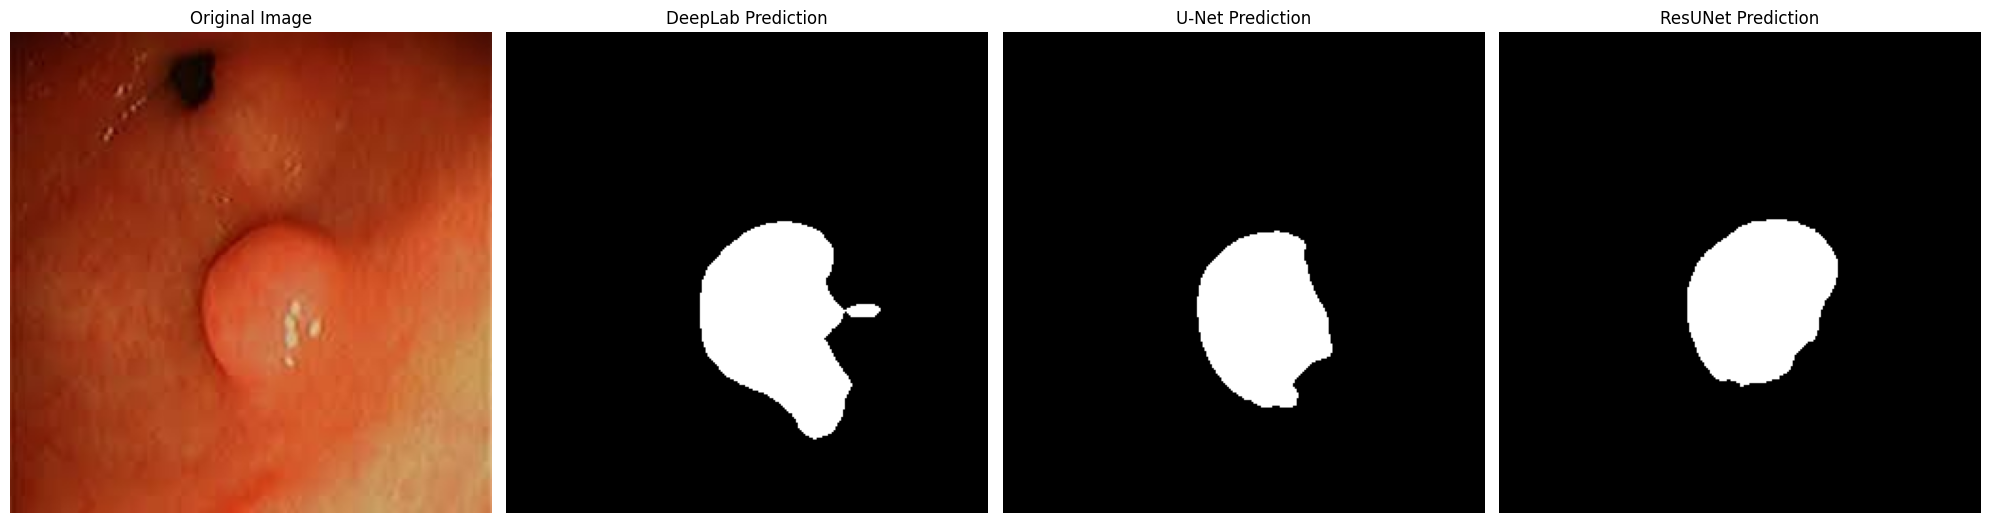

In [21]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

# Set device
device = torch.device("cpu")

# Image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def predict(model, input_image, force_grayscale=False):
    model.eval()
    with torch.no_grad():
        if force_grayscale:
            input_image = input_image.mean(dim=1, keepdim=True)  # Convert to grayscale (1 channel)
        output = model(input_image)
        if isinstance(output, dict):  # For DeepLab
            output = output['out']
        output = torch.sigmoid(output)
        mask = (output.squeeze().cpu().numpy() > 0.7).astype(np.uint8)
        return mask

def compare_all_models(image_path, model_dl, model_unet, model_resunet):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_image = transform(image).unsqueeze(0).to(device)

    # Predict masks
    mask_dl = predict(model_dl, input_image)
    mask_unet = predict(model_unet, input_image, force_grayscale=True)
    mask_resunet = predict(model_resunet, input_image)

    # Plot original + masks
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(image.resize((256, 256)))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask_dl, cmap='gray')
    axs[1].set_title("DeepLab Prediction")
    axs[1].axis('off')

    axs[2].imshow(mask_unet, cmap='gray')
    axs[2].set_title("U-Net Prediction")
    axs[2].axis('off')

    axs[3].imshow(mask_resunet, cmap='gray')
    axs[3].set_title("ResUNet Prediction")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
compare_all_models("test3.jpeg", modeldeeplab, modelunet, modelresunet)


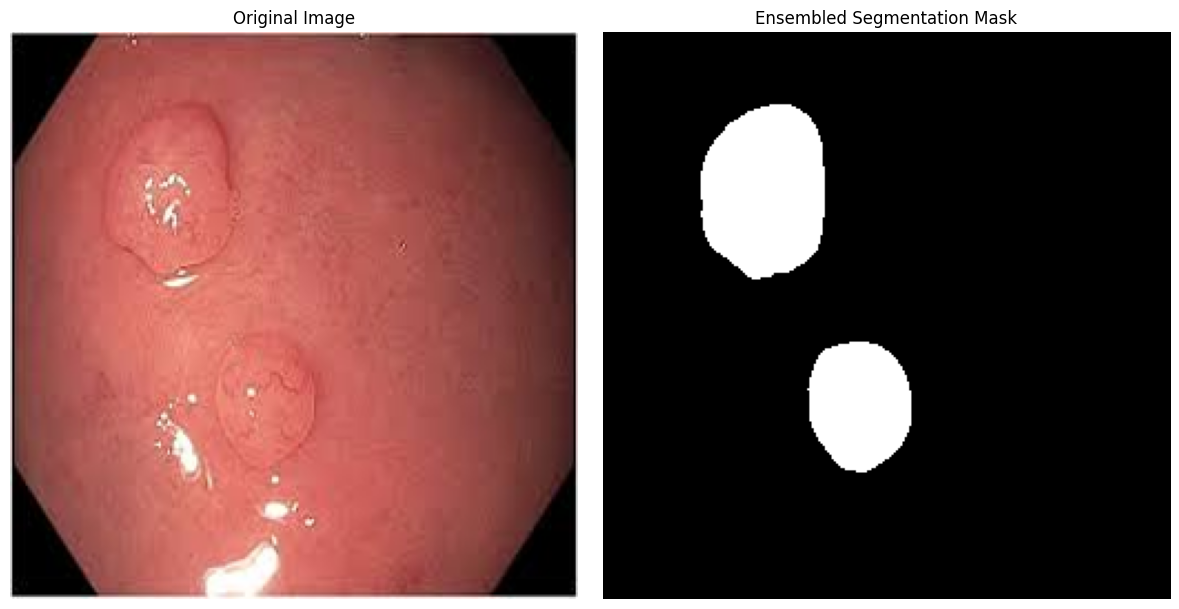

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [25]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Set device
device = torch.device("cpu")

# Transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def get_probability_mask(model, input_image, force_grayscale=False):
    model.eval()
    with torch.no_grad():
        if force_grayscale:
            input_image = input_image.mean(dim=1, keepdim=True)
        output = model(input_image)
        if isinstance(output, dict):  # For DeepLab
            output = output['out']
        output = torch.sigmoid(output)
        return output.squeeze().cpu().numpy()

def ensemble_prediction(image_path, model_dl, model_unet, model_resunet, threshold=0.5):
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Get probability masks
    prob_dl = get_probability_mask(model_dl, input_tensor)
    prob_unet = get_probability_mask(model_unet, input_tensor, force_grayscale=True)
    prob_resunet = get_probability_mask(model_resunet, input_tensor)

    # Resize to same shape if needed (in case of channel mismatch)
    if prob_dl.shape != prob_unet.shape:
        prob_unet = np.resize(prob_unet, prob_dl.shape)
    if prob_resunet.shape != prob_dl.shape:
        prob_resunet = np.resize(prob_resunet, prob_dl.shape)

    # Ensemble: average the predictions
    ensemble_prob = (prob_dl + prob_unet + prob_resunet) / 3.0

    # Threshold to get binary mask
    final_mask = (ensemble_prob > threshold).astype(np.uint8)

    # Show result
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image.resize((256, 256)))
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(final_mask, cmap='gray')
    axs[1].set_title("Ensembled Segmentation Mask")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    return final_mask
ensemble_prediction("test4.jpeg", modeldeeplab, modelunet, modelresunet)